<a href="https://colab.research.google.com/github/BrittonWinterrose/Drug_Review_NLP/blob/master/02_Drug_Data_NLP_Analysis1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drug Data Analysis - Part II 
## *------- Contents -------*

*   **Data Prep Exploration**
*   **ML (Logistic Regression) various Embeddings**
*   **My First CNN Attempt (and Failure)**


 
 

---
Used[ this notebook ](https://github.com/BrittonWinterrose/how-to-solve-NLP)as my template: "*An NLP workshop by Emmanuel Ameisen [(@EmmanuelAmeisen)](https://twitter.com/EmmanuelAmeisen), from Insight AI*"

# Why this dataset matters to me? 
Medicine needs to find better ways to monitor patient progress and success on medications in near-real time inorder to help better treat various medical conditions. I've watched my wife suffer through multiple depression medications during her struggle to find an effective treatment. I believe that a patient log (think captain's log) that would journal the patients experience on a daily or even weekly basis could be invaluable for physicians, care coordinators/networks, and even drug researchers. Providing sentiment analysis generates actionable data that can be reviewed in a manageable amount of time even at scale. 

# The Drug Review Dataset  [(Drugs.com)](http://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29)

### The Orignal Dataset Paper
http://kdd.cs.ksu.edu/Publications/Student/kallumadi2018aspect.pdf

### The purpose of the paper that I am looking at:
"Prediction of the overall patients’ satisfaction with applied medications and sentiments on side effects and effectiveness by employing classification-based sentiment analyses."
"Overall performance when applying sentiment analysis to drug reviews was studied. Therefore, one model... to classify overall patient satisfaction reviews, is trained and evaluated utilizing the corresponding training and test data."


### The Paper's Methodology 
The Data:
*  "We derived three level polarity labels for overall patient satisfaction and three level effectiveness and side effect scores using thresholds as specified in table 1. "
* "Data sets were further split into training and test partitions according to a stratified random sampling scheme with the proportion of 75% and 25%"
* "The total number of individual drugs in the Drugs.com data amounts to 6345"
* 'Drugs.com... conditions [lables & classes] are selected from a defined list, and thus standardized'
* "Sentiment analysis regarding overall patients’ satisfaction... [was] converted to [a] classification problem."
* "In case of overall patient satisfaction, the user ratings were converted to three disjoint classes representing the polarity of a patient’s sentiment regarding the applied medication (negative, neutral, positive). "
>* rating: <= 4, label: -1, reviews: 25% 
>* rating: 4 <> 7, label: 0, reviews: 9%
>* rating: >= 7, label: 1, reviews: 66%
 

For Preprocessing: 
* "Alphabetic characters were transferred to lowercase." 
* "special characters, punctuation and numbers were removed." 
* "preprocessed documents were tokenized on spaces to obtain the overall vocabulary and a feature space representation of each review." 
* "No stop words were removed from the texts. "
* To "reduce the feature space, terms that have a relative document frequency higher than a given threshold were discarded when building the vocabulary".

During Tokenizing:
* "We apply a n-grams approach to represent the user reviews. That means both, single tokens, e.g. words, (unigrams) as well as two or more adjacent tokens (bigrams, tri- grams), e.g. 2- or 3-word expressions"

Modeling: 
* Using the extracted feature representations, 
logistic regression was employed for building sentiment models for the various prediction tasks. 
* Model hyperparameters were tuned using a 5-fold cross validation grid search on the respective training data, tar- geting the best Cohens’s Kappa score. 
* Optimized hyperparameter include: 
>* n-gram number of adjacent tokens
>* token document frequency threshold
>* logistic regression regularization strength. 
As shown in table 1, besides the annotated subset from the Drugs.com data, labels are considerably unbalanced. To compensate for this disproportionate distribution, classification errors were penalized with a weight inversely proportional to the class frequency during training. All experiments were evaluated by computing confusion matrices and deriving both, accuracy and Cohens’s Kappa scores.
 


## My Thoughts for Preprocessing:

* Convert medications into stop word corpus
* Remove common english dict stop words. 
* Convert conditions into stop words and remove.

# Data Preparation 

In [0]:
# I've commented out all the google colab code I built. If you're running this there be sure to uncomment it. 
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials

import keras
import nltk
import pandas as pd
import numpy as np
import codecs
import gensim

!pip install gensim
!pip install tqdm --upgrade
!pip install lime

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import re, string, unicodedata
import nltk
import inflect
from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

from keras.layers import Dense, Input, Flatten, Dropout, Add, Subtract, Multiply, Concatenate, Dot, Maximum
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

from sklearn.preprocessing import LabelBinarizer

import random
from collections import defaultdict

# 1. Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)


## Import, Inspect, and Clean Data

In [0]:
# Import all the data

# Uncomment for first run.
#!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip
#!unzip drugsCom_raw.zip

df_train = pd.read_table('drugsComTrain_raw.tsv')
df_test = pd.read_table('drugsComTest_raw.tsv')

# On this workbook I combined the two datasets, on later ones I kept the orignial data seperated. 
df_main = pd.concat([df_train, df_test], axis=0)
df_main = df_train
df_main.head()

Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           10  
4  November 27, 2016           37

In [0]:
# Turn rating into new "binned" column

def rank_bin(array):
  y_rank = []
  for i in array:
    if i <= 4: # Negative Rating Cut Off (Inclusive)
      y_rank.append(0)
    elif i >= 7: # Positive Rating Cut Off (Inclusive)
      y_rank.append(1)
    else:  # Neutral Rating Cut off 
      y_rank.append(2)
  return y_rank

df_main["rank_bin"] = rank_bin(df_main["rating"])
df_main.rank_bin.value_counts() # Check to see the bin sizes. 

1    106866
0     40075
2     14356
Name: rank_bin, dtype: int64

In [0]:
# Some NAN Nansense.. haha

# These have NAN condition, but this wont effect rating categorization.
df_main.loc[df_main['condition'].isnull()].head(4)

Unnamed: 0                          drugName condition  \
30        51452                      Azithromycin       NaN   
148       61073                              Urea       NaN   
488      132651                           Doxepin       NaN   
733       44297  Ethinyl estradiol / norgestimate       NaN   

                                                review  rating  \
30      "Very good response. It is so useful for me. "    10.0   
148                            "Accurate information."    10.0   
488  "So far so good. Good for me and I can take it...    10.0   
733  "I haven&#039;t been on it for a long time and...     8.0   

                 date  usefulCount  rank_bin  
30    August 18, 2010            1         1  
148      July 2, 2011           13         1  
488  October 20, 2010           25         1  
733  January 24, 2011            1         1

In [0]:
# Oops.. beautiful soup cut a bit strangely here...

# These got trimmed weirdly by the original researchers' scraper. 
# Messed up "Condition"
# Keeping them in the dataset because they don't effect review sentiment
# analysis as the review to rating is still 1 to 1. 

df_main[df_main["condition"].str.contains("</span>",na=False)].head(4)

Unnamed: 0        drugName                                   condition  \
105      220696  Loestrin 24 Fe  2</span> users found this comment helpful.   
196       67383         Provera  4</span> users found this comment helpful.   
243       81588             Yaz  3</span> users found this comment helpful.   
264      132965  Loestrin 24 Fe  4</span> users found this comment helpful.   

                                                review  rating  \
105  "I&#039;m 16 and  I have been on Loestrin 24 f...     3.0   
196  "I&#039;m 24 years old and have always had a p...     1.0   
243  "I took Yaz for a little over 2 years.  From a...     3.0   
264  "Took this pill for 1.) Acne and 2.) Birth Con...     2.0   

                 date  usefulCount  rank_bin  
105  November 3, 2010            2         0  
196    March 27, 2016            4         0  
243      June 1, 2010            3         0  
264     June 24, 2014            4         0

### Poke the data, name it so it's easy to handle
Pretend it's a cat. Check the head. Check the tail.

In [0]:
# Inspect the head.

df_main['text'] = df_main[['review']]
#df_main['rank_bin'].columns = ['class_label']
df_main.rename(columns={'rank_bin':'class_label'}, inplace=True)
df_main.head(3)

Unnamed: 0    drugName                     condition  \
0      206461   Valsartan  Left Ventricular Dysfunction   
1       95260  Guanfacine                          ADHD   
2       92703      Lybrel                 Birth Control   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   

                date  usefulCount  class_label  \
0       May 20, 2012           27            1   
1     April 27, 2010          192            1   
2  December 14, 2009           17            2   

                                                text  
0  "It has no side effect, I take it in combinati...  
1  "My son is halfway through his fourth week of ...  
2  "I used to take another oral contraceptive, wh...

In [0]:
# And tail. 

df_main.tail(3)

Unnamed: 0            drugName              condition  \
161294      187382             Orencia   Rheumatoid Arthritis   
161295       47128  Thyroid desiccated    Underactive Thyroid   
161296      215220        Lubiprostone  Constipation, Chronic   

                                                   review  rating  \
161294  "Limited improvement after 4 months, developed...     2.0   
161295  "I&#039;ve been on thyroid medication 49 years...    10.0   
161296  "I&#039;ve had chronic constipation all my adu...     9.0   

                      date  usefulCount  class_label  \
161294      March 15, 2014           35            0   
161295  September 19, 2015           79            1   
161296   December 13, 2014          116            1   

                                                     text  
161294  "Limited improvement after 4 months, developed...  
161295  "I&#039;ve been on thyroid medication 49 years...  
161296  "I&#039;ve had chronic constipation all my adu...

In [0]:
# Is it big??

df_main.describe(include="all")

Unnamed: 0        drugName      condition  review         rating  \
count   161297.000000          161297         160398  161297  161297.000000   
unique            NaN            3436            884  112329            NaN   
top               NaN  Levonorgestrel  Birth Control  "Good"            NaN   
freq              NaN            3657          28788      33            NaN   
mean    115923.585305             NaN            NaN     NaN       6.994377   
std      67004.445170             NaN            NaN     NaN       3.272329   
min          2.000000             NaN            NaN     NaN       1.000000   
25%      58063.000000             NaN            NaN     NaN       5.000000   
50%     115744.000000             NaN            NaN     NaN       8.000000   
75%     173776.000000             NaN            NaN     NaN      10.000000   
max     232291.000000             NaN            NaN     NaN      10.000000   

                 date    usefulCount    class_label    text  
count          161297  161297.000000  161297.000000  161297  
unique           3579            NaN            NaN  112329  
top     March 1, 2016            NaN            NaN  "Good"  
freq              146            NaN            NaN      33  
mean              NaN      28.004755       0.840549     NaN  
std               NaN      36.403742       0.558601     NaN  
min               NaN       0.000000       0.000000     NaN  
25%               NaN       6.000000       1.000000     NaN  
50%               NaN      16.000000       1.000000     NaN  
75%               NaN      36.000000       1.000000     NaN  
max               NaN    1291.000000       2.000000     NaN

### Use a few regular expressions to clean up poor data, and save it back to disk for future use

In [0]:
# It's going through all the data so this may take a minute. 
# I've deviated from and improved this process a lot in my other workbooks on this dataset. 
# THIS WAS MY GOSH DARN FIRST ATTEMPT SO BE KIND. :)

def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"(\d)", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

df_clean_text = standardize_text(df_main, "text")

# Save locally. 
df_clean_text.to_csv("clean_data.csv")
print('Saved file clean_data.csv to your local drive')

# Save to Google Drive
#df_clean_text.to_csv("clean_data.csv")
#uploaded = drive.CreateFile({'title': "clean_data.csv"})
#uploaded.SetContentFile("clean_data.csv")
#uploaded.Upload()
#print('Uploaded file clean_data.csv with ID {}'.format(uploaded.get('id')))

df_clean_text.head(3)

Saved file clean_data.csv to your local drive


Unnamed: 0    drugName                     condition  \
0      206461   Valsartan  Left Ventricular Dysfunction   
1       95260  Guanfacine                          ADHD   
2       92703      Lybrel                 Birth Control   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   

                date  usefulCount  class_label  \
0       May 20, 2012           27            1   
1     April 27, 2010          192            1   
2  December 14, 2009           17            2   

                                                text  
0  "it has no side effect, i take it in combinati...  
1  "my son is halfway through his fourth week of ...  
2  "i used to take another oral contraceptive, wh...

In [0]:
# Just to be sure it saved, I'll read it back and check that it looks right.
# This can be used as a Checkpoint to comeback to so we don't have to re-standardize again. 
df_clean_text = pd.read_csv("clean_data.csv")
df_clean_text.tail(4)

Unnamed: 0  Unnamed: 0.1            drugName              condition  \
161293      161293        127085      Metoclopramide        Nausea/Vomiting   
161294      161294        187382             Orencia   Rheumatoid Arthritis   
161295      161295         47128  Thyroid desiccated    Underactive Thyroid   
161296      161296        215220        Lubiprostone  Constipation, Chronic   

                                                   review  rating  \
161293  "I was given this in IV before surgey. I immed...     1.0   
161294  "Limited improvement after 4 months, developed...     2.0   
161295  "I&#039;ve been on thyroid medication 49 years...    10.0   
161296  "I&#039;ve had chronic constipation all my adu...     9.0   

                      date  usefulCount  class_label  \
161293    November 1, 2011           34            0   
161294      March 15, 2014           35            0   
161295  September 19, 2015           79            1   
161296   December 13, 2014          116            1   

                                                     text  
161293  "i was given this in iv before surgey  i immed...  
161294  "limited improvement after  months, developed ...  
161295  "i   ve been on thyroid medication  years, i s...  
161296  "i   ve had chronic constipation all my adult ...

### Data Overview

Inspect the class balance.

In [0]:
df_clean_text.groupby("class_label").count()

Unnamed: 0  Unnamed: 0.1  drugName  condition  review  rating  \
class_label                                                                  
0                 40075         40075     40075      39828   40075   40075   
1                106866        106866    106866     106310  106866  106866   
2                 14356         14356     14356      14260   14356   14356   

               date  usefulCount    text  
class_label                               
0             40075        40075   40075  
1            106866       106866  106866  
2             14356        14356   14356

We've got some oversampling of the Positive results class (#1), but negative (#0) is pretty large too.

### Check out the length of these sentences

85.72599614375964
1941


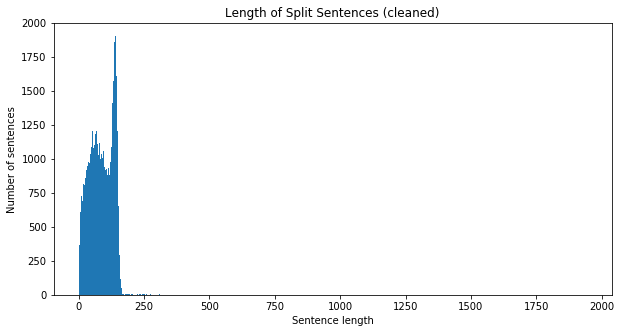

In [0]:
# I like this method so I keep coming back to it often.

print(df_clean_text['text'].str.split().str.len().mean())
print(df_clean_text['text'].str.split().str.len().max())
df_clean_text["strlen"] = df_clean_text['text'].str.split().str.len()
df_clean_text.describe()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Length of Split Sentences (cleaned)')
plt.hist(df_clean_text["strlen"], bins=1941)
plt.show()

In [0]:
# I explore the distribution of the words here.

_a = df_clean_text.loc[df_clean_text["strlen"] >= 1000].strlen.count()
_b = df_clean_text.loc[df_clean_text["strlen"] >= 750].strlen.count()
_c = df_clean_text.loc[df_clean_text["strlen"] >= 250].strlen.count()
_d = df_clean_text.loc[df_clean_text["strlen"] >= 180].strlen.count()
_e = df_clean_text.loc[df_clean_text["strlen"] >= 100].strlen.count()
_f = df_clean_text.loc[df_clean_text["strlen"] < 100].strlen.count()
print (" # of Reviews by Length \n %s >1000 words \n %s >750 words \n %s >250 words \n %s >180 words \n %s >100 words \n %s <100 words\n" % (_a,_b,_c,_d,_e,_f))

 # of Reviews by Length 
 5 >1000 words 
 10 >750 words 
 171 >250 words 
 347 >180 words 
 66388 >100 words 
 94909 <100 words



### Drop the long sentence outliers.

85.25610885029977
180
Max sentence length is 180


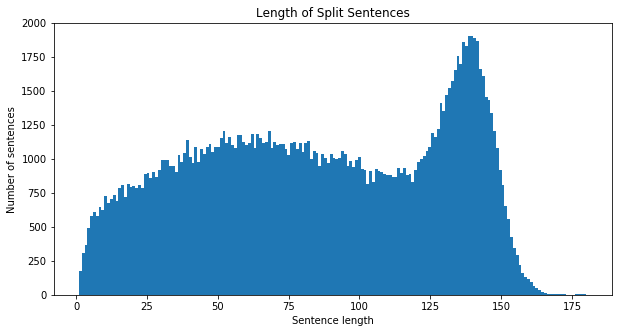

In [0]:
# Now lets drop all the long rows

df_clean_text = df_clean_text.loc[df_clean_text["strlen"] <= 180]
print(df_clean_text['text'].str.split().str.len().mean())
print(df_clean_text['text'].str.split().str.len().max())
print("Max sentence length is %s" % max(df_clean_text["strlen"]))

#df_clean_text.describe()

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Length of Split Sentences')
plt.hist(df_clean_text["strlen"], bins=180)
plt.show()

In [0]:
# Sentence lengths after cleaning

_a = df_clean_text.loc[df_clean_text["strlen"] >= 1000].strlen.count()
_b = df_clean_text.loc[df_clean_text["strlen"] >= 750].strlen.count()
_c = df_clean_text.loc[df_clean_text["strlen"] >= 250].strlen.count()
_d = df_clean_text.loc[df_clean_text["strlen"] >= 180].strlen.count()
_e = df_clean_text.loc[df_clean_text["strlen"] >= 100].strlen.count()
_f = df_clean_text.loc[df_clean_text["strlen"] < 100].strlen.count()
print (" # of Reviews by Length \n %s >1000 words \n %s >750 words \n %s >250 words \n %s >180 words \n %s >100 words \n %s <100 words\n" % (_a,_b,_c,_d,_e,_f))

 # of Reviews by Length 
 0 >1000 words 
 0 >750 words 
 0 >250 words 
 5 >180 words 
 66046 >100 words 
 94909 <100 words



## Our data is clean, now it needs to be prepared
Now that our inputs are more reasonable, I transform the inputs in a way our model can understand. This implies:
- Tokenizing sentences to a list of separate words
- Create a Stopwords dictionary
- Apply stopwords and further cleaning
- Creating a train test split
- Inspecting our data a little more to validate results

In [0]:
# Tokenize the text
# This takes a few seconds

tokenizer = RegexpTokenizer(r'\w+')
df_clean_text["tokens"] = df_clean_text["text"].apply(tokenizer.tokenize)
df_clean_text.head()

Unnamed: 0  Unnamed: 0.1                  drugName  \
0           0        206461                 Valsartan   
1           1         95260                Guanfacine   
2           2         92703                    Lybrel   
3           3        138000                Ortho Evra   
4           4         35696  Buprenorphine / naloxone   

                      condition  \
0  Left Ventricular Dysfunction   
1                          ADHD   
2                 Birth Control   
3                 Birth Control   
4             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  class_label  \
0       May 20, 2012           27            1   
1     April 27, 2010          192            1   
2  December 14, 2009           17            2   
3   November 3, 2015           10            1   
4  November 27, 2016           37            1   

                                                text  strlen  \
0  "it has no side effect, i take it in combinati...      16   
1  "my son is halfway through his fourth week of ...     142   
2  "i used to take another oral contraceptive, wh...     135   
3  "this is my first time using any form of birth...      88   
4  "suboxone has completely turned my life around...     130   

                                              tokens  
0  [it, has, no, side, effect, i, take, it, in, c...  
1  [my, son, is, halfway, through, his, fourth, w...  
2  [i, used, to, take, another, oral, contracepti...  
3  [this, is, my, first, time, using, any, form, ...  
4  [suboxone, has, completely, turned, my, life, ...

### Create Custom Stopwords Using the Drug Names

On previous inspection a large portion of the corpus appeared to be drug names themselves. Rather than the analysis looking at the individual drug names and using them to create a potentially biased weighting on the names I will elect to attempt to remove them by creating a custom drug name corpus. 

In [0]:
# Import NLTK stopwords. 
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

In [0]:
# Define normalization function

#https://www.kdnuggets.com/2018/03/text-data-preprocessing-walkthrough-python.html
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def normalize(words):
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words
  
# I could have gone further with this to lemmatize or stem these words but this is good for now. 


In [0]:
# Google 20k most common english words to make sure drug & condition stopwords are pure. 
# https://github.com/first20hours/google-10000-english

# my Windows pc doesn't have wget working right now, but it does have a GTX-1080Ti. 
# So I'll download this manually.
#!wget = https://raw.githubusercontent.com/first20hours/google-10000-english/master/20k.txt
words_common = "20k.txt"

words_common = [line.strip() for line in open("20k.txt", 'r')]
print ("loaded words_common")

loaded words_common


In [0]:
# Create a custom drugnames stopwords list. 

# Unique list with all drug names by frequency
drugs = df_clean_text["drugName"].value_counts()
drugs = drugs.reset_index()

# Run re standardization drug name text
drugs = standardize_text(drugs, 'index')
drugs = drugs['index'].tolist()

# Run normalization on drug names
drugs = normalize(drugs)
drugs = pd.DataFrame(drugs, columns=['name'])

# Tokenize names and combine in
drugs['name'] = drugs['name'].apply(tokenizer.tokenize)
drugs = [word for tokens in drugs['name'] for word in tokens]
print("Tokenized: ",len(drugs))
#print(all_drugs)

# Check drug names and remove any common words (google 20k most common)
drugs_cleaned = [token for token in drugs if token not in words_common]
print("Cleaned: ",len(drugs_cleaned))
#print(drugs_cleaned)


drugs = pd.DataFrame(drugs_cleaned, columns=['name'])
drugs = drugs['name'].value_counts()
drugs = drugs.rename_axis('names').reset_index()
drugs = drugs["names"].tolist()
print("Cleaned and de-duped: ",len(drugs))

drug_stopwords = drugs
drugs_stop = pd.DataFrame(drug_stopwords, columns=['drugs_stopwords'])
drugs_stop[0:20]

Tokenized:  5050
Cleaned:  3858
Cleaned and de-duped:  2878


drugs_stopwords
0         acetaminophen
1       pseudoephedrine
2         phenylephrine
3             estradiol
4               codeine
5      dextromethorphan
6   hydrochlorothiazide
7      chlorpheniramine
8           guaifenesin
9               ethinyl
10            metformin
11       hydrocortisone
12              mucinex
13           amlodipine
14      diphenhydramine
15             peroxide
16              tylenol
17            polymyxin
18                  hfa
19            tenofovir

In [0]:
# Extend the english stopwords file to include our drug stopwords. 

print ("NLTK stopword list length: ",len(stopwords),'words')
stopwords.extend(drug_stopwords)
print ("Added custom stopwords")
print ("New stopword list length: ",len(stopwords),'words')

NLTK stopword list length:  179 words
Added custom stopwords
New stopword list length:  3057 words


In [0]:
#### Skipping this part because I already have it downloaded. ####

# Save copy of normalized df to google drive.
# Refresh auth if needed

# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# drugs_stop.to_csv("drugname_stopwords.csv")
# uploaded = drive.CreateFile({'title': "drugname_stopwords.csv"})
# uploaded.SetContentFile("drugname_stopwords.csv")
# uploaded.Upload()
# print('Uploaded file "drugname_stopwords.csv" with ID {}'.format(uploaded.get('id')))

### Normalizing & Stopword Removal in Action - Exploring word frequencies. 

In [0]:
# Features BEFORE normalizing & removing stopwords

all_words = [word for tokens in df_clean_text["tokens"] for word in tokens]
df_clean_text["tokens_len"] = [len(tokens) for tokens in df_clean_text["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s tokens in total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(df_clean_text["strlen"]))

13573620 tokens in total, with a vocabulary size of 45837
Max sentence length is 180


In [0]:
# ClEAN TOKENS!!!
# This takes a long time
# TDQM helps with monitoring this process while running long for loops.

# Apply Normalization and word 
df_clean_text['old_tokens'] = df_clean_text["tokens"]
df_clean_text['tokens'] = [normalize(token) for token in tqdm(df_clean_text["tokens"])]

# Save a copy locally. 
df_clean_text.to_csv("cleaned_normalized_data.csv")
print('Uploaded file clean_data.csv')

# Save copy of normalized df to google drive.
# Refresh auth if needed

#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

#df_clean_text.to_csv("cleaned_normalized_data.csv")
#uploaded = drive.CreateFile({'title': "cleaned_normalized_data.csv"})
#uploaded.SetContentFile("cleaned_normalized_data.csv")
#uploaded.Upload()
#print('Uploaded file clean_data.csv with ID {}'.format(uploaded.get('id')))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 160955/160955 [04:41<00:00, 571.33it/s]


Uploaded file clean_data.csv


### Inspect the final cleaned corpus

In [0]:
# Features AFTER normalizing & removing stopwords

cleaned_words = [word for tokens in df_clean_text["tokens"] for word in tokens]
df_clean_text["tokens_len"] = [len(tokens) for tokens in df_clean_text["tokens"]]
cleanedVOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(cleaned_words), len(cleanedVOCAB)))
print("Max sentence length is %s" % max(df_clean_text["strlen"]))
print("We got rid of {} words, or {:2.3f}% of the total token count".format((len(all_words)-len(cleaned_words)),(len(cleaned_words) / len(all_words)*100)))

6288505 words total, with a vocabulary size of 45837
Max sentence length is 180
We got rid of 7285115 words, or 46.329% of the total token count


In [0]:
# See how the words change

print ("our words before cleaning")
# See some of the words left in our vocab. 
df_words = []
df_words = pd.DataFrame(all_words)
u = df_words[0].value_counts()
print(u.head(5), u.tail(5))

# See some of the words left in our vocab. 

print ("\nour words after cleaning")
df_words = []
df_words = pd.DataFrame(cleaned_words)
u = df_words[0].value_counts()
print(u.head(5), u.tail(5))

our words before cleaning
i      850411
and    428619
the    403453
to     320104
it     315854
Name: 0, dtype: int64 byproduct       1
revulsion       1
procanimide     1
sitagliption    1
kcals           1
Name: 0, dtype: int64

our words after cleaning
day       57489
side      53256
taking    51049
years     46684
pain      45491
Name: 0, dtype: int64 ani           1
modulate      1
frustation    1
erges         1
pita          1
Name: 0, dtype: int64


# Testing ML with different Embeddings
 
 Tutorial Notes: *Machine Learning on images can use raw pixels as inputs. Fraud detection algorithms can use customer features. What can NLP use?*
 
*A natural way to represent text for computers is to encode each character individually, this seems quite inadequate to represent and understand language. Our goal is to first create a useful embedding for each sentence (or tweet) in our dataset, and then use these embeddings to accurately predict the relevant category.*

*The simplest approach we can start with is to use a bag of words model, and apply a logistic regression on top. A bag of words just associates an index to each word in our vocabulary, and embeds each sentence as a list of 0s, with a 1 at each index corresponding to a word present in the sentence.*

# Bag of Words Counts

In [0]:
df_clean_text = pd.read_csv("cleaned_normalized_data.csv")
df_clean_list = pd.DataFrame(df_clean_text["tokens"])
df_clean_list = df_clean_text.tokens.tolist()
print (df_clean_text["class_label"].values)

[1 1 2 ... 0 1 1]


In [0]:
# Here is where I split the model into test/train sets. 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Defining the vectorizer function. 
def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

# Here I define my corpus and lables. These are used throughout all the other models/processes.
list_corpus = df_clean_list
list_labels = df_clean_text["class_label"].values

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

### BoW Embedding Visualization 
Now take the embeddings, visualize them and look to identify some structure. In a perfect world, embeddings would be so distinct that the 3 classes would be perfectly separated. Visualizing data in 20k dimensions is hard, so project it down to 2.

colormapper= {0: 0, 1: 1, 2: 2}


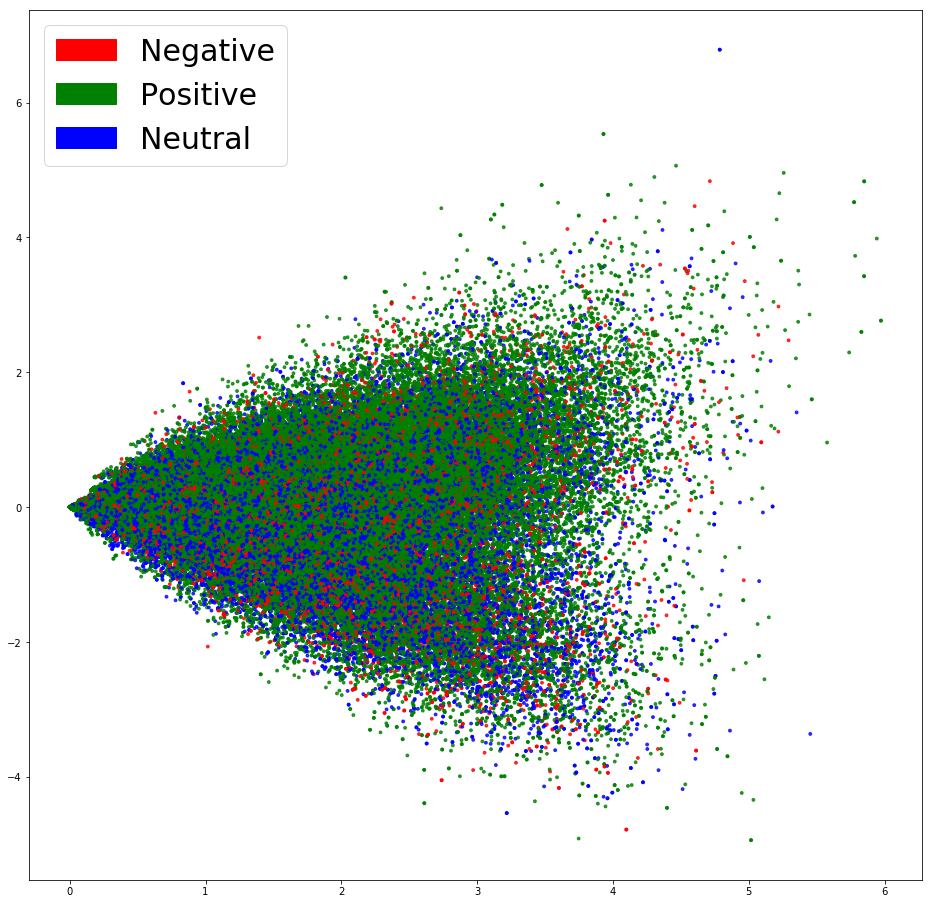

In [0]:
# Lets make an awesome plot

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt


def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2) # Truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        print ('colormapper=',color_mapper)
        #print ('colorColumn=',color_column)
        colors = ['blue','green','red']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='red', label='Negative')
            blue_patch = mpatches.Patch(color='blue', label='Neutral')
            green_patch = mpatches.Patch(color='green', label='Positive')
            plt.legend(handles=[red_patch, green_patch, blue_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_counts, y_train)
plt.show()

These embeddings don't look very cleanly separated. I'll see if I can still fit a useful model on them.



## Logistic Regression w/ BoW: Fitting a classifier
Starting with a logistic regression is a good idea. It is simple, often gets the job done, and is easy to interpret.

In [0]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30, class_weight='balanced', solver='sag', 
                         multi_class='multinomial', n_jobs=-1, random_state=40, 
                         verbose=1, max_iter = 1000)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)

# My first run that completed successfully is below... lol

# convergence after 6022 epochs took 3242 seconds
# [Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 54.0min finished


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 164 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.7min finished


### BoW Logistic Regression: Performance Evaluation

Start by looking at some metrics to see if the classifier performed well at all.

In [0]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

# My first run: 
# 200 epoch, C=.1 accuracy = 0.569, precision = 0.580, recall = 0.569, f1 = 0.567
# accuracy = 0.568, precision = 0.576, recall = 0.568, f1 = 0.567

# My second run:
# 1000 epoch C=10
# accuracy = 0.748, precision = 0.806, recall = 0.748, f1 = 0.768

# My last run: 
# C = 10, 8000 epoch, took 6572 to get to convergence
# accuracy = 0.751, precision = 0.795, recall = 0.751, f1 = 0.767


accuracy = 0.751, precision = 0.794, recall = 0.751, f1 = 0.767


### BoW Confusion Matrix for performance inspection
A metric is one thing, but in order to make an actionnable decision, we need to actually inspect the kind of mistakes our classifier is making. Let's start by looking at the confusion matrix.

In [0]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()
    #plt.ylabel('True label', fontsize=30)
    #plt.xlabel('Predicted label', fontsize=30)

    return plt

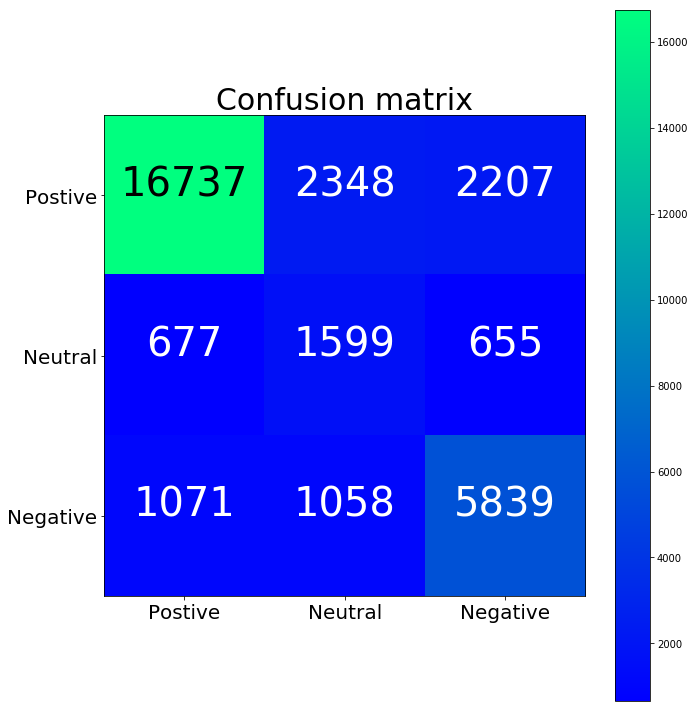

In [0]:
# Plot the confusion matrix for Bag of Words

cm = confusion_matrix(y_test, y_predicted_counts, labels = [1,2,0])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Postive','Neutral','Negative'], normalize=False, title='Confusion matrix')
plt.show()


My classifier predicts class 3 (the middle), unreasonably well as it is overrepresented in the model. 

~~Depending on the use case, this seems desirable (a false positive is quite a high cost for law enforcement for example).~~



### BoW Word Vector Ranking - Feature Inspection 
Looking at the features our classifier is using to make decisions.

In [0]:
# Gets a list of the most important and least important word vectors

def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

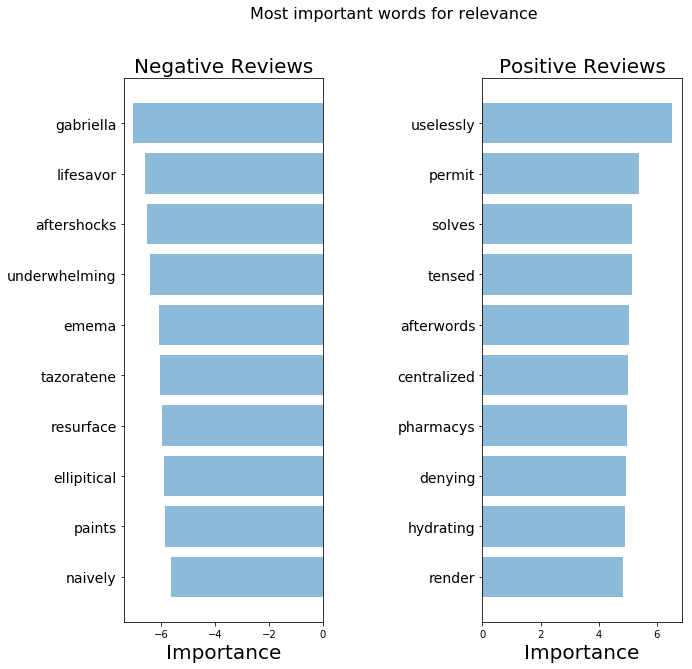

In [0]:
# Define important words plot function and plot Bag-of-Words' important words

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Negative Reviews', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Positive Reviews', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Our classifier correctly picks up on some patterns ('emema','solves'), but clearly seems to be overfitting on some irrelevant terms (bac, centralized)

# Trying TFIDF Bag of Words
*A slightly more subtle approach. On top of our bag of words model, we use a TF-IDF (Term Frequency, Inverse Document Frequency) which means weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise.*

In [0]:
# Apply a TF-IDF weights filter.  
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

#### TFIDF + BoW  Embedding Visualization

colormapper= {0: 0, 1: 1, 2: 2}


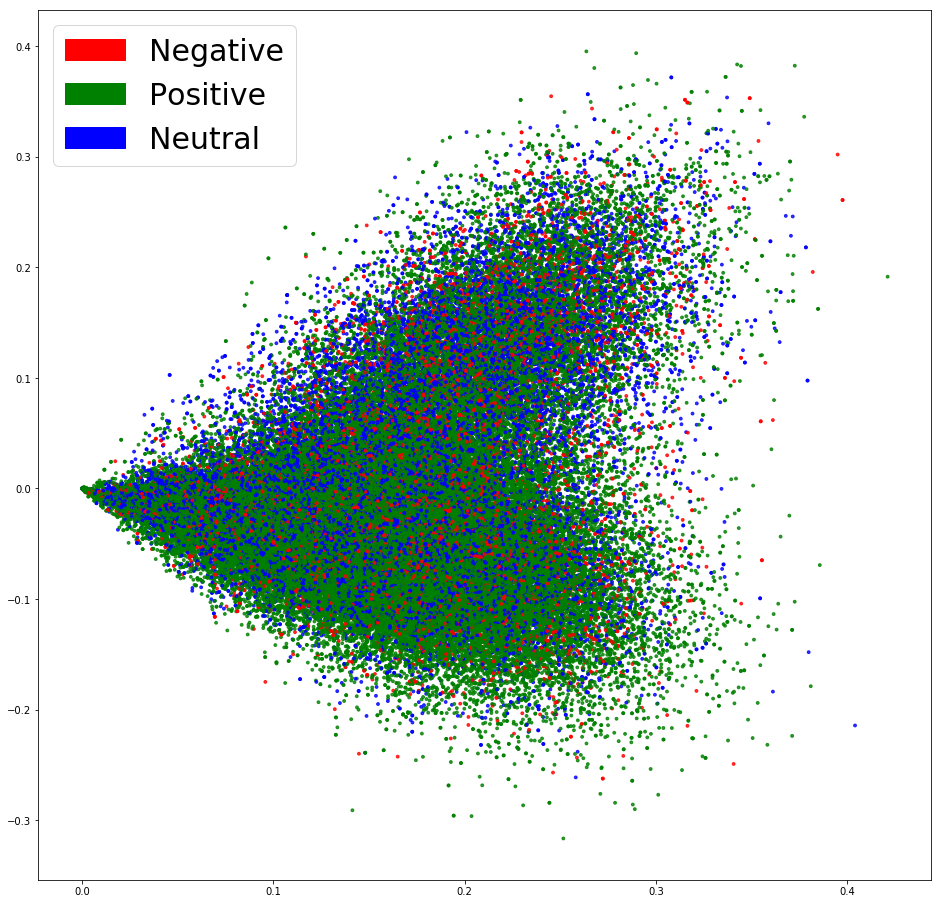

In [0]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

These embeddings look much more separated, let's see if it leads to better performance.

## Logistic Regression w/ TFIDF + BoW

In [0]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='sag', 
                         multi_class='multinomial', n_jobs=-1, random_state=40, verbose=1, max_iter = 1000)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 164 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.7min finished


### TFIDF + BoW Logistic Regression: Performance Evaluation

In [0]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf, 
                                                                       recall_tfidf, f1_tfidf))

accuracy = 0.715, precision = 0.764, recall = 0.715, f1 = 0.734


The results aren't any better, we can still see if they translate to an actual difference in our use case.

### TFIDF + BoW Confusion Matrix for performance inspection

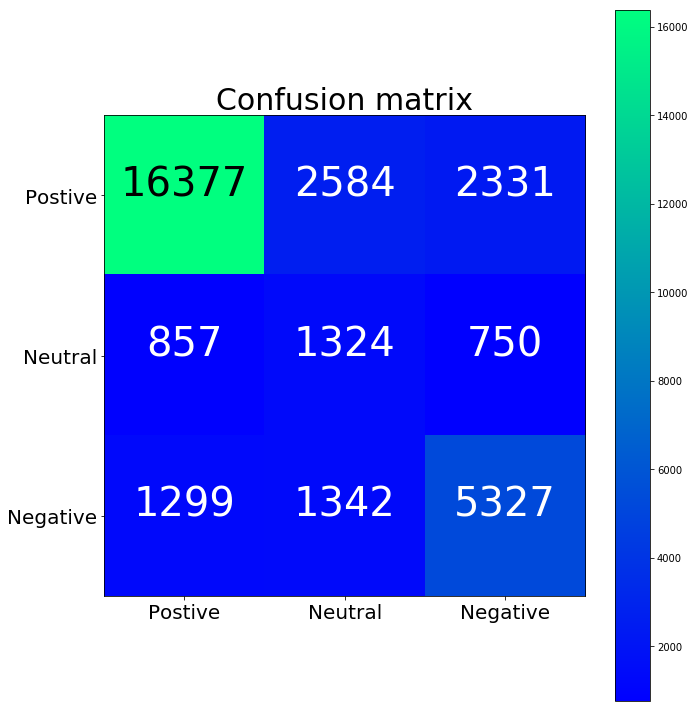

TFIDF confusion matrix
[[16377  2584  2331]
 [  857  1324   750]
 [ 1299  1342  5327]]
BoW confusion matrix
[[16737  2348  2207]
 [  677  1599   655]
 [ 1071  1058  5839]]


In [0]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf, labels = [1,2,0])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['Postive','Neutral','Negative'], normalize=False, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

This model performed more poorly for me, but it performed better for the original demo dataset. 

### TFIDF Word Vector Ranking - Which words were most important? 


In [0]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

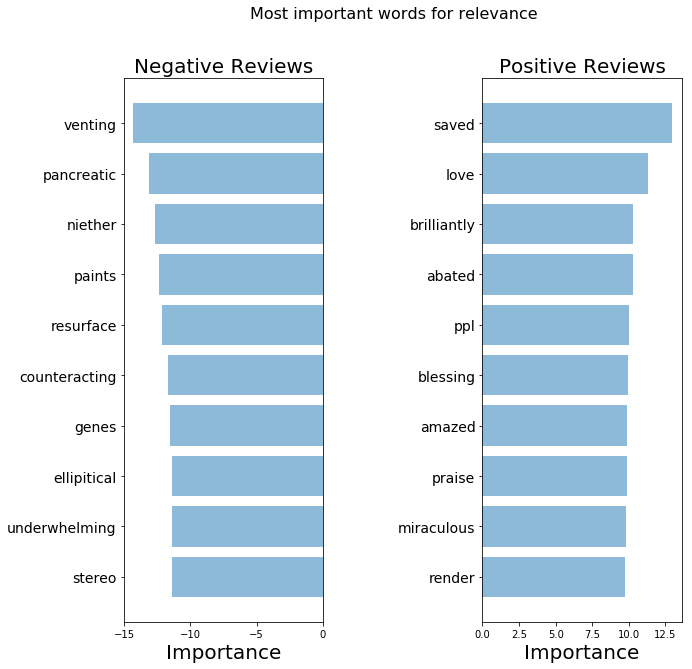

In [0]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']]
top_words = [a[1] for a in importance_tfidf[1]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

*The words it picked up look much more relevant! Although our metrics on our held out validation set haven't increased much, we have much more confidence in the terms our model is using, and thus would feel more comfortable deploying it in a system that would interact with customers.* 

I agree. The word relevance definitely seems to have improved. 

# Am I capturing semantic meaning?
Tutorial Notes: *These first models have managed to pick up on high signal words. However, it is unlikely that we will have a training set containing all relevant words. To solve this problem, we need to capture the semantic meaning of words. Meaning we need to understand that words like 'good' and 'positive' are closer than apricot and 'continent'.*



# Try Word2Vec - Map the sentence average embeddings.  
Tutorial Notes: *Word2vec is a model that was pre-trained on a very large corpus, and provides embeddings that map words that are similar close to each other. A quick way to get a sentence embedding for a classifier, is to average word2vec scores of all words in each sentence.*

In [0]:
# ON COLAB
#downloaded = drive.CreateFile({'id': "0B7XkCwpI5KDYNlNUTTlSS21pQmM"})
#downloaded.GetContentFile("GoogleNews-vectors-negative300.bin.gz")

## Download Word2Vec model.

In [0]:
# This file of vectors is a 3.2gb binary file. It takes a little while to load. 

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

## Calculate W2V Scores

In [0]:
# Here we calculate the average word2vec scores for all the words in each sentence.

def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, list_corpus, generate_missing=False):
    embeddings = pd.DataFrame(list_corpus)[0].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [0]:
embeddings = get_word2vec_embeddings(word2vec, list_corpus)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels, 
                                                                                        test_size=0.2, random_state=40)

## Word 2 Vec Embedding Visualization 

colormapper= {0: 0, 1: 1, 2: 2}


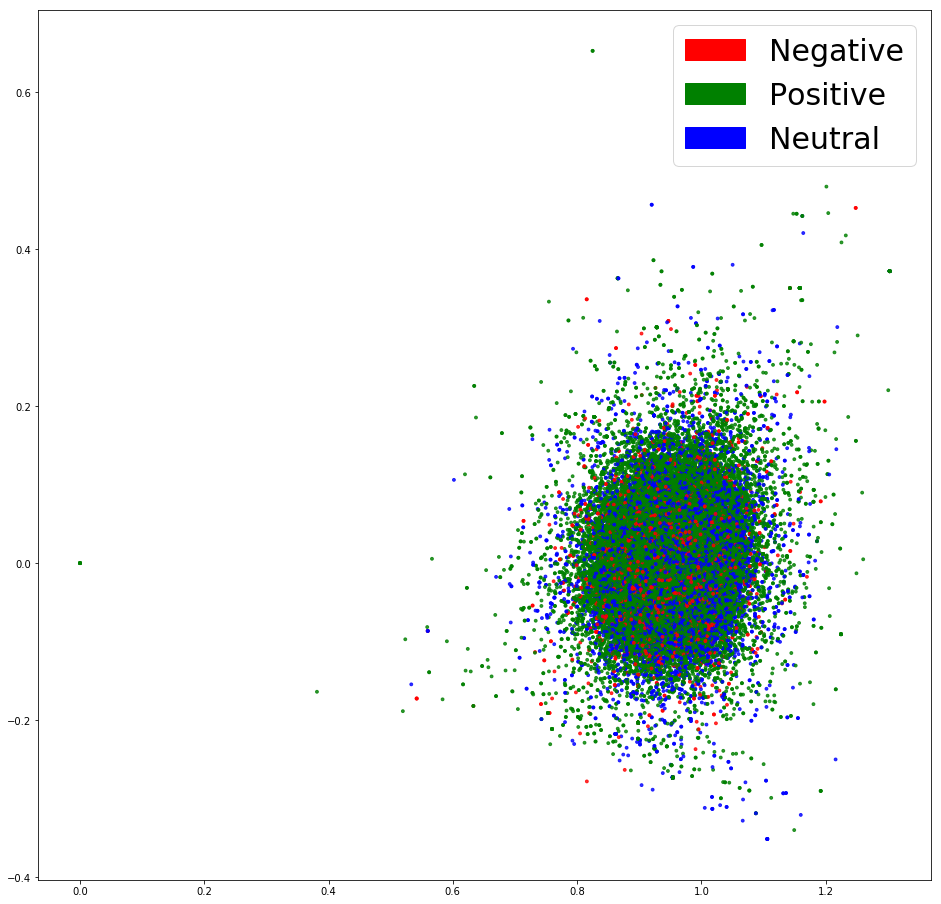

In [0]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(embeddings, list_labels)
plt.show()

These definitely look... ***different***. Lets try the logistic regression again.

## Logistic Regression w/ Word2Vec

In [0]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='sag', 
                             multi_class='multinomial', n_jobs=-1, random_state=40, 
                             verbose=1, max_iter = 1000)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 132 epochs took 82 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.4min finished


### W2V Logistic Regression: Performance Evaluation 

In [0]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec, 
                                                                       recall_word2vec, f1_word2vec))

accuracy = 0.437, precision = 0.582, recall = 0.437, f1 = 0.479


Still getting better, let's plot the confusion matrix

### W2V Confusion Matrix for performance inspection

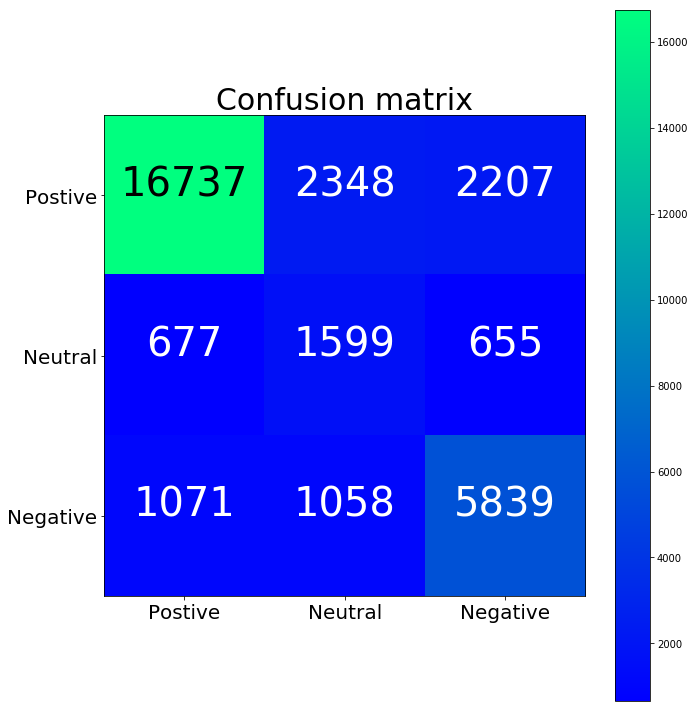

Word2Vec confusion matrix
[[9540 5500 6252]
 [ 980  971  980]
 [2347 2071 3550]]
TFIDF confusion matrix
[[16377  2584  2331]
 [  857  1324   750]
 [ 1299  1342  5327]]
BoW confusion matrix
[[16737  2348  2207]
 [  677  1599   655]
 [ 1071  1058  5839]]


In [0]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec, labels = [1,2,0])
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['Postive','Neutral','Negative'], normalize=False, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

~~Our model is strictly better in all regards than the first two models, this is promissing!~~
These vectors just aren't helping for this medical dataset. Even with the removal of many drug name based stopwords.

### Show W2V hidden words vectors using Lime, a black box explainer 
Tutorial Note: *Since the W2V model does not use a vector with one dimension per word, (**it is using scores of weights**) it gets much harder to directly see which words are most relevant to the classification. In order to provide some explainability, you can leverage a black box explainer such as LIME.*

In [0]:
# Use Lime to peer into the depths of the models and see what is really going on.

X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [0]:
# These are the formulas that let us take a peak inside using lime. 

def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["Negative","Positive", "Neutral"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [0]:
visualize_one_exp(X_test_data, y_test_data, 65)

Index: 65
True class: Neutral


In [0]:
visualize_one_exp(X_test_data, y_test_data, 60)

Index: 60
True class: Positive


In [0]:
# Do some black box searching. 

random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'Negative',
    1: 'Positive',
    2: 'Neutral'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

### Use lime's text explainer to identify contributing words and then display them as we did the Word Vector Rankings

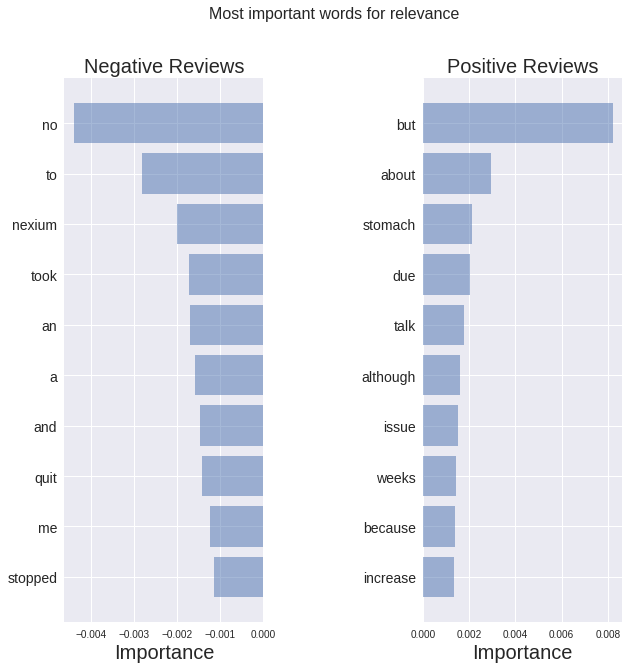

In [0]:
# Sort words by reviews
top_words = sorted_contributions['Relevant']['supporters'][:10].index.tolist()
top_scores = sorted_contributions['Relevant']['supporters'][:10].tolist()
bottom_words = sorted_contributions['Relevant']['detractors'][:10].index.tolist()
bottom_scores = sorted_contributions['Relevant']['detractors'][:10].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

~~Looks like very relevant words are picked up! This model definitely seems to make decisions in a very understandable way.~~
These models are obviously breaking down on this dataset. 

# Last Method to Attempt:  BUILD MY FIRST CNN for text classification
Tutorial Notes: *Using a Convolutional Neural Network for sentence classification. While not as popular as RNNs, they have been proven to get competitive results (sometimes beating the best models), and are very fast to train, making them a perfect choice for this tutorial.*

First, let's embed our text!

In [0]:
# apparently CNN's dont like negative numbers, I used negatives previously.  
#df_shorter["rank_bin"] = df_shorter["rank_bin"].replace(-1,2)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.preprocessing import OneHotEncoder

EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(list_corpus)
sequences = tokenizer.texts_to_sequences(list_corpus)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(list_labels)

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 43525 unique tokens.
(43526, 300)


In [0]:
# Binarize the labels! 

lb = LabelBinarizer()
lb.fit(list_labels)
lb.classes_
lb.transform(list_labels)
#np.asarray(df_shorter["rank_bin"]).reshape(-1,1)

Now, we will define a simple Convolutional Neural Network

In [0]:
# Create my first ConvNet

def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)  
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

Now let's train our Neural Network

In [0]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM, 
                3, False)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 35, 300)      13057800    input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 33, 128)      115328      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 32, 128)      153728      embedding_3[0][0]                
__________________________________________________________________________________________________
conv1d_11 

My attempt at this particular model failed on the first night. So there is no additional section to analyze. 

In [0]:
# This isn't working and it's 4:52 AM so I am throwing in the towel on the CNN tonight. 

# model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=15)

# My Takeaways
### New Material and Techniques
This entire workbook (with the exception of data importing ) has been new to me. It was my first experience with most of these NLP terms & techniques but working through it has been such an incredible learning opportunity as I was able to take the tutorial as a template and adapt it to the use around my own dataset while incorperating my own insights for the data prep stages and custom drug-name stopword corpus. 


### Drug Stopword Limitations
There still appears to be some drug names making their way through the stopwords as the drug-name stopword corpus is limited to correctly spelled words, and no lemmitzing or stemming of words is used to help combat mispelling. 

### Next Steps
I am excited to take what I have learned here and explore it further in my next workbook where I will attempt to use an LSTM to get even better performance results with the same dataset. I think I will also incorperate a corpus to help with embedding performance. 

###  Thank you!
Feel free to follow me on [myTwitter](https://twitter.com/BWinterrose)